In [1]:
import os
import uproot
import numpy as np
import pandas as pd
import awkward as ak

# Input ROOT file
file_path = "DNNTrain_1000_2.root"
with uproot.open(file_path) as file:
    tree = file["tree"]

    t5_innerRadius = np.concatenate(tree["t5_innerRadius"].array(library="np"))
    t5_bridgeRadius = np.concatenate(tree["t5_bridgeRadius"].array(library="np"))
    t5_outerRadius = np.concatenate(tree["t5_outerRadius"].array(library="np"))
    t5_pt = np.concatenate(tree["t5_pt"].array(library="np"))
    t5_eta = np.concatenate(tree["t5_eta"].array(library="np"))
    t5_phi = np.concatenate(tree["t5_phi"].array(library="np"))
    t5_isFake = np.concatenate(tree["t5_isFake"].array(library="np"))

    # Use these indices to extract two from each below
    t5_t3_idx0 = np.concatenate(tree["t5_t3_idx0"].array(library="np"))
    t5_t3_idx1 = np.concatenate(tree["t5_t3_idx1"].array(library="np"))

    # Each of these is two features below this line, index with above.
    t3_pt = np.concatenate(tree["t3_pt"].array(library="np"))

    t3_0_r = np.concatenate(tree["t3_0_r"].array(library="np"))
    t3_0_z = np.concatenate(tree["t3_0_z"].array(library="np"))
    t3_0_eta = np.concatenate(tree["t3_0_eta"].array(library="np"))
    t3_0_phi = np.concatenate(tree["t3_0_phi"].array(library="np"))
    t3_0_layer = np.concatenate(tree["t3_0_layer"].array(library="np"))

    t3_2_r = np.concatenate(tree["t3_2_r"].array(library="np"))
    t3_2_z = np.concatenate(tree["t3_2_z"].array(library="np"))
    t3_2_eta = np.concatenate(tree["t3_2_eta"].array(library="np"))
    t3_2_phi = np.concatenate(tree["t3_2_phi"].array(library="np"))
    t3_2_layer = np.concatenate(tree["t3_2_layer"].array(library="np"))

    t3_4_r = np.concatenate(tree["t3_4_r"].array(library="np"))
    t3_4_z = np.concatenate(tree["t3_4_z"].array(library="np"))
    t3_4_eta = np.concatenate(tree["t3_4_eta"].array(library="np"))
    t3_4_phi = np.concatenate(tree["t3_4_phi"].array(library="np"))
    t3_4_layer = np.concatenate(tree["t3_4_layer"].array(library="np"))

# Max value to normalize the z, r variables by.
z_max = np.max([t3_4_z, t3_2_z, t3_0_z])
r_max = np.max([t3_4_r, t3_2_r, t3_0_r])

print(f'Z max: {z_max}, R max: {r_max}')

/tmp/ipykernel_2661692/2203387148.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Z max: 267.2349853515625, R max: 110.10993957519531


In [2]:
import torch

# Function to fetch T3 features for given T5 indices
def fetch_t3_features_for_t5(t3_feature, t5_t3_idx):
    return t3_feature[t5_t3_idx]

# Initialize the features list without the T5 standalone variables at the beginning
features = []

# Now, extract T3 features indexed by t5_t3_idx0 and t5_t3_idx1
for t3_feature in [t3_0_eta, t3_0_z/z_max, t3_0_r/r_max, t3_0_layer,
                   t3_2_eta, t3_2_z/z_max, t3_2_r/r_max, t3_2_layer,
                   t3_4_eta, t3_4_z/z_max, t3_4_r/r_max, t3_4_layer]:
    features.append(fetch_t3_features_for_t5(t3_feature, t5_t3_idx0))

for t3_feature in [t3_2_eta, t3_2_z/z_max, t3_2_r/r_max, t3_2_layer,
                   t3_4_eta, t3_4_z/z_max, t3_4_r/r_max, t3_4_layer]:
    features.append(fetch_t3_features_for_t5(t3_feature, t5_t3_idx1))

# Append T5 standalone variables at the end of the features list
features += [
    t5_eta, np.log10(t5_innerRadius), np.log10(t5_bridgeRadius), np.log10(t5_outerRadius)
]

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t5_isFake_filtered = t5_isFake[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [3]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

# Initialize model, loss function, and optimizer
model = MyNeuralNetwork().to(device)
loss_function = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.0025)

labels_tensor = 1 - torch.tensor(t5_isFake_filtered, dtype=torch.float32)

# Remove rows with NaN in input_features_tensor and corresponding labels
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]

# Get indices of each class
class_zero_indices = (filtered_labels == 0).nonzero(as_tuple=True)[0]
class_one_indices = (filtered_labels == 1).nonzero(as_tuple=True)[0]

print(np.shape(class_zero_indices), np.shape(class_one_indices))

# Randomly sample from the majority class to match the number of samples in the minority class
undersampled_class_one_indices = class_one_indices[torch.randperm(len(class_one_indices))[:len(class_zero_indices)]]

# Combine the minority class indices with the downsampled majority class indices
undersampled_indices = torch.cat((class_zero_indices, undersampled_class_one_indices), dim=0)

# Create new dataset with undersampled indices
undersampled_dataset = TensorDataset(filtered_inputs[undersampled_indices], filtered_labels[undersampled_indices])

total_count = len(undersampled_dataset)
train_count = int(0.8 * total_count)  # 80% for training
test_count = total_count - train_count  # Remaining 20% for testing

train_dataset, test_dataset = random_split(undersampled_dataset, [train_count, test_count])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)
loss_log = []

def evaluate_model(loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += targets.size(0)
            correct += (predicted == targets.bool()).sum().item()
    model.train()
    return 100 * correct / total

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
    
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs.squeeze(), targets)

        loss_log.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_accuracy = evaluate_model(train_loader)
    test_accuracy = evaluate_model(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

Using device: cuda
torch.Size([2191566]) torch.Size([7430055])
Epoch [1/150], Loss: 0.5471, Train Acc: 74.53%, Test Acc: 74.54%
Epoch [2/150], Loss: 0.4306, Train Acc: 76.59%, Test Acc: 76.62%
Epoch [3/150], Loss: 0.4629, Train Acc: 77.63%, Test Acc: 77.60%
Epoch [4/150], Loss: 0.4505, Train Acc: 78.62%, Test Acc: 78.58%
Epoch [5/150], Loss: 0.5213, Train Acc: 78.61%, Test Acc: 78.57%
Epoch [6/150], Loss: 0.4518, Train Acc: 79.05%, Test Acc: 78.97%
Epoch [7/150], Loss: 0.4823, Train Acc: 78.60%, Test Acc: 78.59%
Epoch [8/150], Loss: 0.4590, Train Acc: 79.18%, Test Acc: 79.14%
Epoch [9/150], Loss: 0.5079, Train Acc: 79.20%, Test Acc: 79.20%
Epoch [10/150], Loss: 0.4748, Train Acc: 78.49%, Test Acc: 78.46%
Epoch [11/150], Loss: 0.4145, Train Acc: 79.04%, Test Acc: 79.03%
Epoch [12/150], Loss: 0.4589, Train Acc: 79.73%, Test Acc: 79.71%
Epoch [13/150], Loss: 0.4376, Train Acc: 79.62%, Test Acc: 79.65%
Epoch [14/150], Loss: 0.4386, Train Acc: 79.83%, Test Acc: 79.79%
Epoch [15/150], Loss: 

In [8]:
torch.save(model.state_dict(), "model.pth")

In [4]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    model.eval()  # Set the model to evaluation mode
    inputs = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.808360755443573
Feature importances:
Feature 22 importance: 0.3911
Feature 21 importance: 0.3739
Feature 23 importance: 0.2352
Feature 20 importance: 0.1585
Feature 4 importance: 0.0146
Feature 3 importance: 0.0142
Feature 9 importance: 0.0083
Feature 1 importance: 0.0077
Feature 13 importance: 0.0055
Feature 0 importance: 0.0048
Feature 17 importance: 0.0042
Feature 12 importance: 0.0040
Feature 16 importance: 0.0040
Feature 15 importance: 0.0027
Feature 11 importance: 0.0021
Feature 8 importance: 0.0017
Feature 5 importance: 0.0016
Feature 14 importance: 0.0013
Feature 7 importance: 0.0010
Feature 10 importance: 0.0006
Feature 6 importance: 0.0003
Feature 18 importance: 0.0002
Feature 2 importance: -0.0014
Feature 19 importance: -0.0014


/tmp/ipykernel_2661692/52354147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


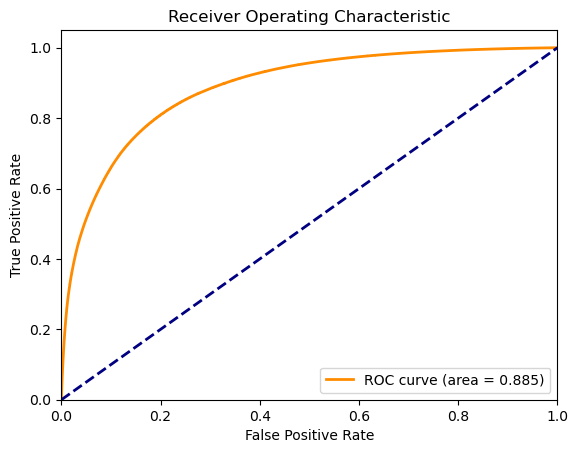

In [5]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [7]:
# Target TPR value
target_tpr = 0.82

# Find the closest TPR value to the target and its corresponding FPR and threshold
closest_index = np.argmin(np.abs(tpr - target_tpr))
closest_tpr = tpr[closest_index]
closest_fpr = fpr[closest_index]
closest_threshold = thresholds[closest_index]

closest_tpr, closest_fpr, closest_threshold

(0.8199999865411495, 0.21112528666715946, 0.4858359)

In [6]:
# Make sure the model is in evaluation mode
model.eval()

# Accessing weights and biases for layer1
layer1_weights = model.layer1.weight.data.cpu().numpy()
layer1_biases = model.layer1.bias.data.cpu().numpy()

# Accessing weights and biases for layer2
layer2_weights = model.layer2.weight.data.cpu().numpy()
layer2_biases = model.layer2.bias.data.cpu().numpy()

# Accessing weights and biases for output_layer
output_layer_weights = model.output_layer.weight.data.cpu().numpy()
output_layer_biases = model.output_layer.bias.data.cpu().numpy()

def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()  # New line for better readability

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()  # New line for better readability


print_formatted_weights_biases(layer1_weights, layer1_biases, "0")
print_formatted_weights_biases(layer2_weights, layer2_biases, "2")
print_formatted_weights_biases(output_layer_weights, output_layer_biases, "4")

ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_0[32] = {
-5.3775663f, -0.0629070f, -0.1107947f, 0.0547313f, 0.8083491f, 0.1614532f, 0.0011228f, 0.2760398f, -2.2796352f, -0.0870581f, -0.7871540f, -0.2550607f, -0.2695814f, 0.1847538f, 1.7765446f, -0.2647117f, -0.2673643f, 0.0752851f, -3.7754159f, 0.8185130f, 2.6870177f, 5.0170417f, -0.1383601f, -1.1201516f, -4.5405807f, 0.1246142f, 0.0223448f, 0.4101483f, -1.7402967f, -0.8376405f, -0.0931148f, 0.1320779f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_0[24][32] = {
{ 0.3037412f, 0.0133543f, -0.0844910f, -0.0245358f, 0.0005115f, 0.0164969f, -0.1552105f, 0.0255788f, 0.1520063f, 0.0218900f, 0.0638683f, 0.0974756f, -0.0242341f, 0.1272557f, -0.1174381f, 0.0573553f, 0.2197373f, 0.0390040f, 0.0512601f, 0.0179152f, -0.0107118f, -0.4261344f, 0.1402164f, 0.6939149f, 0.0262515f, -0.0187614f, -0.0206603f, 0.0090553f, -0.2223053f, -0.1501996f, 0.1199791f, -0.0223365f },
{ -0.6120934f, -0.0565208f, 0.4023429f, 0.2622005f, 0.1356343f, -0.1782811f, -0.